# Composite priors

A common usecase is to have a multidimensional prior with different distributions in each dimension. We achieve this with scipy and torch distributions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import scipy.stats
import numpy as np

import pylab as plt

from toolz import compose
from swyft.prior import Prior, PriorTruncator
from swyft.utils import tensor_to_array, array_to_tensor

Here we define our priors. The `parameter_dimensions` variable is a list of integers which define the dimensionality of each random variable within the composite.

In [3]:
loc = torch.tensor([1.0, -3.2])
scale = torch.tensor([0.1, 2.1])

upper = torch.tensor([2.5, 3.1])
lower = torch.tensor([0.1, -2.0])

parameter_dimensions = [len(loc), len(upper)]
n_parameters = sum(parameter_dimensions)

## SciPy Distributions

SciPy distributions are simple to use. Put the relevant functions in a list and define the `parameter_dimensions` value.

In [4]:
normal_scipy = scipy.stats.norm(loc, scale)
uniform_scipy = scipy.stats.uniform(lower, upper)

composite_prior_scipy = Prior.composite_prior(
    cdfs=[normal_scipy.cdf, uniform_scipy.cdf],
    icdfs=[normal_scipy.ppf, uniform_scipy.ppf],
    log_probs=[normal_scipy.logpdf, uniform_scipy.logpdf],
    parameter_dimensions=parameter_dimensions,
)

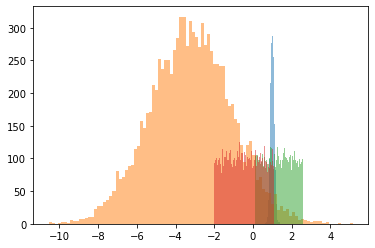

In [5]:
samples_scipy = PriorTruncator(composite_prior_scipy, bound=None).sample(10_000)
for i in range(n_parameters):
    _ = plt.hist(samples_scipy[:, i], bins=100, alpha=0.5)

## Torch Distributions

This requires the application of `Prior.conjugate_tensor_func` to convert the numpy arrays to tensors then the output tensors back to numpy arrays. The prior samples and simulations are usually saved as numpy data within swyft, so we must convert to use a pytorch distribution.

We apply `Prior.conjugate_tensor_func` with a functional idiom.

In [6]:
normal = torch.distributions.Normal(loc, scale)
uniform = torch.distributions.Uniform(lower, upper)

composite_prior_torch = Prior.composite_prior(
    cdfs=list(map(Prior.conjugate_tensor_func, [normal.cdf, uniform.cdf])),
    icdfs=list(map(Prior.conjugate_tensor_func, [normal.icdf, uniform.icdf])),
    log_probs=list(map(Prior.conjugate_tensor_func, [normal.log_prob, uniform.log_prob])),
    parameter_dimensions=parameter_dimensions,
)

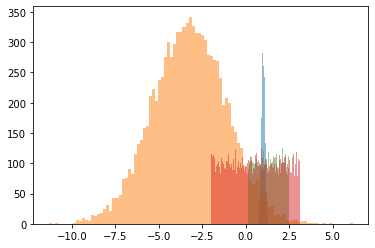

In [7]:
samples = PriorTruncator(composite_prior_torch, bound=None).sample(10_000)
for i in range(n_parameters):
    _ = plt.hist(samples[:, i], bins=100, alpha=0.5)

## Extending

Note that the above prior definition is quite flexible. If you want to define your own prior with another system it will work as long as you can specify the `cdf`, `icdf`, `log_prob`, and `parameter_dimensions`. The most obvious use case would be to define a prior from a variety of packages.